Imports

In [78]:
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim
import cv2 
import glob

## Import Landlab components
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder

#SPACE model
from landlab.components import Space #SPACE model
from landlab.components import SpaceLargeScaleEroder #basically SPACE 2.0 -- use this 
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import StreamPowerEroder
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file

%matplotlib inline

Setting up the Raster Model 

In [79]:
#Set grid parameters
num_rows = 20
num_columns = 20
node_spacing = 2.00
node_next_to_outlet = num_columns + 1


#Set Model Time Parameters for Space
timestep = 100
run_time = 1000000 #years
sp_interval = 1

uplift_rate = .001 # m/year
uplift_per_timestep = uplift_rate * timestep

#Instantiate model grid
mg = RasterModelGrid((num_rows, num_columns), node_spacing)

#Set constant random seed for consistent topographic roughness
np.random.seed(seed = 5000)

#Add field ’topographic elevation’ to the grid
mg.add_zeros('node', 'topographic__elevation')

#topographic roughness
random_noise = np.random.rand(len(mg.node_y)) /1000 #impose topography values on model grid


#Add field 'soil__depth' to the grid
mg.add_zeros('node', 'soil__depth')

#Set 2 m of initial soil depth at core nodes
mg.at_node['soil__depth'][mg.core_nodes] = 2.0 #meters 

#Add field 'bedrock__elevation' to the grid
mg.add_zeros('bedrock__elevation', at='node')

#Sum 'soil__depth' and 'bedrock__elevation' to yield 'topographic elevation'
mg.at_node["topographic__elevation"] += (mg.node_y / 10. + mg.node_x / 10. + np.random.rand(len(mg.node_y)) / 10.0)

#topo = mg.node_y/100000 + mg.node_x/100000

#topographic roughness
#random_noise = np.random.rand(len(mg.node_y)) /1000 #impose topography values on model grid
#mg['node']['topographic__elevation'] += (topo + random_noise) 


#mg.at_node["topographic__elevation"][:] = mg.at_node["bedrock__elevation"]
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"] - mg.at_node["soil__depth"]
#mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]



Setting Boundary Conditions of the Model Grid

In [80]:
#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)
outlet_node = mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)
print(outlet_node)


None


Instantiate the Components

In [81]:
#Parameters for SPACE and Fastscape
K_sed = 0.01
K_sp = 0.001
K_br = 0.001
F_f = 0.0
phi = 0.0
H_star = 1.0
v_s = 5.0
m_sp = 0.5
n_sp = 1.0
sp_crit_sed = 0
sp_crit_br = 0

#Instantiate the Flow accumulator
fr = PriorityFloodFlowRouter(mg, flow_metric='D8', suppress_out = True)

#Instantiate the Flow accumulator
fa = FlowAccumulator(mg, flow_director='D8') 

#Instantiate the depressionfinder and router as df
df = DepressionFinderAndRouter(mg,pits = 'flow__sink_flag', reroute_flow = True) 

#instantiate the fascape eroder as fsc 
fsc = FastscapeEroder(mg, K_sp, m_sp, n_sp)  

#Instantiate SPACE model with chosen parameters as sp
spe = SpaceLargeScaleEroder(mg, K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br)
sp = Space(mg, K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br)

#spe = StreamPowerEroder(mg, K_sp = K_sp)



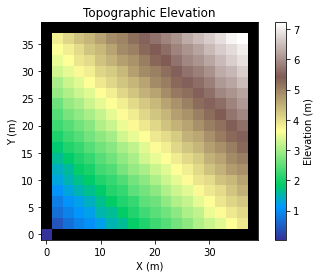

In [82]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

remember: need to run fascape-- probably for like 100000 years to create the initial topography until it reaches the steady state 

also need to create a function to fine where to start collecting the sed_flux values

Using Fastspace Bring the Model to steady state

In [83]:
sp_fsc_yrs = np.arange(0, 100, 25) #for every 5 million yrs space will run for 10 years
fsc_img_interval = np.arange(0, 100, 10) #creates a numpy array with numbers in the interval of 1000 between 1 and the 100000
fsc_timestep = 100
fsc_uplift_rate = .001
fsc_tot_uplift = fsc_timestep*fsc_uplift_rate #total uplift per timestep

#run for 45 million years 
for x in range(200): #actually do for 450000 in final model
    #mg.at_node['bedrock__elevation'][:] += uplift_per_timestep  #adding uplift to the bedrock
    #mg.at_node['topographic__elevation'][:]= mg.at_node['bedrock__elevation'] + mg.at_node['soil__depth'] #changing the elevation to account for the uplift
    print(x)

    if x in sp_fsc_yrs:
        print("space" + str(x))
        fa.run_one_step()
        df.map_depressions()
        fsc.run_one_step(90)
        #then run space for 10 years
        for z in range(10):
            fr.run_one_step()
            spe.run_one_step(dt = 1) 
            mg.at_node['bedrock__elevation'][0]-= fsc_uplift_rate  #adding uplift to the bedrock
            mg.at_node['topographic__elevation'][0]-= mg.at_node['bedrock__elevation'][0] - mg.at_node['soil__depth'][0] #changing the elevation to account for the uplift
    
            #mg.at_node["topographic__elevation"][0]-= 0.001 # Uplift
            #mg.at_node["bedrock__elevation"][0]-= 0.001 # Uplift
    else: 
        fa.run_one_step()
        df.map_depressions()
        fsc.run_one_step(100)

    if x in fsc_img_interval: #then get an image
        print(x)
        #Instantiate figure as empty plot
        fig = plt.figure()
        #Instantiate subplot as empty plot
        plot= plt.subplot()
        #Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
        imshow_grid(mg,"topographic__elevation", plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
        fig.savefig("fsc_topo_images/fsc_topo_" + str(x) + ".png")
        plt.close()
        
    mg.at_node['bedrock__elevation'][0]-= fsc_tot_uplift  #adding uplift to the bedrock
    mg.at_node['topographic__elevation'][0] = mg.at_node['bedrock__elevation'][0] - mg.at_node['soil__depth'][0] #changing the elevation to account for the uplift

    

0
space0
0
1
2
3
4
5
6
7
8
9
10
10
11
12
13
14
15
16
17
18
19
20
20
21
22
23
24
25
space25
26
27
28
29
30
30
31
32
33
34
35
36
37
38
39
40
40
41
42
43
44
45
46
47
48
49
50
space50
50
51
52
53
54
55
56
57
58
59
60
60
61
62
63
64
65
66
67
68
69
70
70
71
72
73
74
75
space75
76
77
78
79
80
80
81
82
83
84
85
86
87
88
89
90
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


fsc_img_interval = np.arange(500000, 30000000, 500000) #creates a numpy array with numbers in the interval of 1000 between 1 and the 100000
#run for 5 million years
fsc_tot_time = 30000000
fsc_elapsed_time = 0
fsc_timestep = 100
fsc_steps = fsc_tot_time / fsc_timestep

while fsc_elapsed_time < fsc_tot_time:
    fa.run_one_step()
    df.map_depressions()
    fsc.run_one_step(dt = fsc_timestep)

    if fsc_elapsed_time in fsc_img_interval: #if you are at the correct interval to retrieve a photo from 
        print(fsc_elapsed_time)
        #Instantiate figure as empty plot
        fig = plt.figure()
        #Instantiate subplot as empty plot
        plot= plt.subplot()
        #Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
        imshow_grid(mg,"topographic__elevation", plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
        fig.savefig("fsc_topo_images/fsc_topo_" + str(fsc_elapsed_time) + ".png")
        plt.close()
        
    fsc_elapsed_time += fsc_timestep
    
    mg.at_node["bedrock__elevation"][0] -= 0.001 # Uplift
    mg.at_node["topographic__elevation"][0] -= 0.001 #add uplift





    

In [84]:
#produce the video with all of the pngs
fsc_topo_image_list = []
fsc_topo_size = None
for file in glob.glob('fsc_topo_images/*.png'):
    img = cv2.imread(file)
    height, width, layers = img.shape
    fsc_topo_size = (width, height)
    fsc_topo_image_list.append(img)

fsc_topo_out = cv2.VideoWriter('fsc_topo_video.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, fsc_topo_size)
for i in range(len(fsc_topo_image_list)):
    fsc_topo_out.write(fsc_topo_image_list[i])
fsc_topo_out.release()

Show the Topographic Elevation

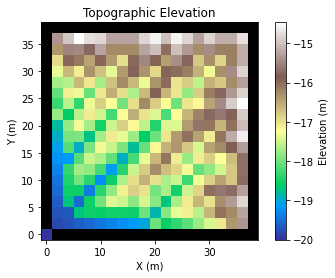

In [85]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

C:\Users\gsbir\AppData\Local\Temp\ipykernel_21592\2872523809.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  prof_plot.show()


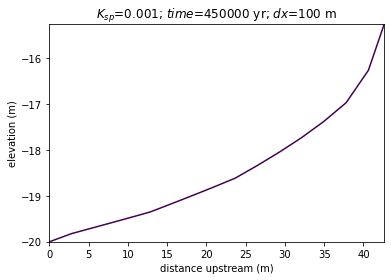

In [86]:
#make channel profile
prf = ChannelProfiler(mg,number_of_watersheds=1,main_channel_only=True,minimum_channel_threshold=node_spacing**2)

prf.run_one_step()

        #Show the profile
prof_plot=plt.figure(1)
title_text = f"$K_{{sp}}$={.001}; $time$={450000} yr; $dx$={timestep} m"
prf.plot_profiles(xlabel='distance upstream (m)', ylabel='elevation (m)', title=title_text)
prof_plot.savefig("prof_images/profile_" + str(450000) + ".png")
prof_plot.show()

Run the Model

In [87]:
#Set Model Time Parameters for Space
timestep = 100
run_time = 100000 #years
sp_interval = 10000

uplift_rate = .001 # m/year
uplift_per_timestep = uplift_rate * timestep

#Set elapsed time to zero
elapsed_time = 0

#Set timestep count to zero
count = 0

#Array to save sediment flux values and is currently filled with 0s
sed_flux = [0] * (run_time) 
uplift_array = [0] * (run_time)

space_img_interval = np.arange(0, run_time, sp_interval)
uplift_interval = np.arange(500000,700000, 1)
#This will iterate through all of the years needed and will essentially run the model
while elapsed_time < run_time: #time units of years
    if elapsed_time in uplift_interval:
        uplift_rate = .002
        uplift_per_timestep == .002 * timestep #half way through for a few years there will be an increase in uplift--- see how the system reacts  
    else:
        uplift_rate = .001
        uplift_per_timestep == .001 * timestep
    
    mg.at_node['bedrock__elevation'][0] -= uplift_per_timestep  #adding uplift to the bedrock
    mg.at_node['topographic__elevation'][0] = mg.at_node['bedrock__elevation'][0] - mg.at_node['soil__depth'][0] #changing the elevation to account for the uplift

    fa.run_one_step()
    sp.run_one_step(dt = timestep)
    sed_flux[count] = mg.at_node["sediment__flux"][node_next_to_outlet]
    uplift_array[count] = uplift_rate
    elapsed_time += timestep
    

    #save the figure to separate folder and make sure to close each figure (saves on memory)
    
    if elapsed_time in space_img_interval: #only produce image on the interval
        print(elapsed_time)
        #make sediment flux plot
        #Instantiate figure as an empty plot
        fig = plt.figure()

        #Instantiate subplot as an empty plot
        sedfluxplot = plt.subplot()

        #Creates the information in the graph with the runtim values from 0 to the end of the run_time , and the sed_flux array creates while the model was running
        sedfluxplot.plot(np.arange(run_time),sed_flux, color = 'k', linewidth = 3)

        #Add axis labels to the plot 
        sedfluxplot.set_title('Sedimentograph') #title
        sedfluxplot.set_xlabel('Time [yr]') #x axis label
        sedfluxplot.set_ylabel(r'Sediment flux [m$^3$/yr]') #y axis label
        fig.savefig("sed_images/sed_flux_" + str(elapsed_time) + ".png")
        plt.close()

        #make uplift plot
        fig = plt.figure()

        #Instantiate subplot as an empty plot
        uplift_plt = plt.subplot()

        #Creates the information in the graph with the runtim values from 0 to the end of the run_time , and the sed_flux array creates while the model was running
        uplift_plt.plot(np.arange(run_time), uplift_array, color = 'k', linewidth = 3)

        #Add axis labels to the plot 
        uplift_plt.set_title('Uplift Rate') #title
        uplift_plt.set_xlabel('Time [yr]') #x axis label
        uplift_plt.set_ylabel(r'Uplift [m$/yr]') #y axis label
        fig.savefig("uplift_images/uplift_" + str(elapsed_time) + ".png")
        plt.close()

        #make channel profile
        prf = ChannelProfiler(mg,number_of_watersheds=1,main_channel_only=True,minimum_channel_threshold=node_spacing**2)

        prf.run_one_step()

        #Show the profile
        prof_plot=plt.figure(1)
        title_text = f"$K_{{sp}}$={.001}; $time$={elapsed_time} yr; $dx$={timestep} m"
        prf.plot_profiles(xlabel='distance upstream (m)', ylabel='elevation (m)', title=title_text)
        prof_plot.savefig("prof_images/profile_" + str(elapsed_time) + ".png")
        plt.close()
        
        #make topomap
        #Instantiate figure as empty plot
        figelev = plt.figure()

        #Instantiate subplot as empty plot
        plot = plt.subplot()

        #Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
        imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
        figelev.savefig("sp_topo_images/topo_" + str(elapsed_time) + ".png")
        plt.close()
        
    count += timestep #have this as the very last thing in loop


10000
20000
30000
40000
50000
60000
70000
80000


ValueError: The number of watersheds requested by the ChannelProfiler is greater than the number in the domain with channel_definition_field area. [ 0.]

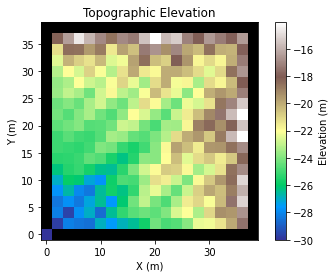

In [ ]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

Making Videos of sedFlux, topomap and channel profile

In [ ]:
#sed flux video
sed_flux_image_list = []
sed_flux_size = None
for file in glob.glob('sed_flux_images/*.png'):
    img = cv2.imread(file)
    height, width, layers = img.shape
    sed_flux_size = (width, height)
    sed_flux_image_list.append(img)

sed_flux_out = cv2.VideoWriter('sed_flux_SPACE.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, fsc_topo_size)
for i in range(len(sed_flux_image_list)):
    sed_flux_out.write(sed_flux_image_list[i])
sed_flux_out.release()

#sed flux video
uplift_image_list = []
uplift_size = None
for file in glob.glob('uplift_images/*.png'):
    img = cv2.imread(file)
    height, width, layers = img.shape
    uplift_size = (width, height)
    uplift_image_list.append(img)

uplift_out = cv2.VideoWriter('uplift_SPACE.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, fsc_topo_size)
for i in range(len(uplift_image_list)):
    uplift_out.write(uplift_image_list[i])
uplift_out.release()

#topo video
topo_image_list = []
topo_size = None
for file in glob.glob('sp_topo_images/*.png'):
    img = cv2.imread(file)
    height, width, layers = img.shape
    topo_size = (width, height)
    topo_image_list.append(img)

topo_out = cv2.VideoWriter('topo_SPACE.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, fsc_topo_size)
for i in range(len(topo_image_list)):
    topo_out.write(topo_image_list[i])
topo_out.release()

#chanel profile video
prof_image_list = []
prof_size = None
for file in glob.glob('prof_images/*.png'):
    img = cv2.imread(file)
    height, width, layers = img.shape
    prof_size = (width, height)
    prof_image_list.append(img)

prof_out = cv2.VideoWriter('profile_SPACE.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, fsc_topo_size)
for i in range(len(prof_image_list)):
    prof_out.write(prof_image_list[i])
prof_out.release()

Create Channel Profile

prf = ChannelProfiler(mg,
                      number_of_watersheds=1,
                      main_channel_only=True,
                      minimum_channel_threshold=node_spacing**2)

prf.run_one_step()

#Show the profile
plt.figure(1)
title_text = f"$K_{{sp}}$={.001}; $time$={elapsed_time} yr; $dx$={timestep} m"
prf.plot_profiles(xlabel='distance upstream (m)', ylabel='elevation (m)', title=title_text)

Text(0, 0.5, 'Sediment flux [m$^3$/yr]')

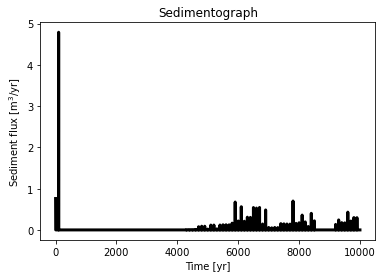

In [ ]:
#Instantiate figure as an empty plot
fig = plt.figure()

#Instantiate subplot as an empty plot
sedfluxplot = plt.subplot()

#Creates the information in the graph with the runtim values from 0 to the end of the run_time , and the sed_flux array creates while the model was running
sedfluxplot.plot(np.arange(run_time),sed_flux,'-', color = 'k', linewidth = 3)

#Add axis labels to the plot 
sedfluxplot.set_title('Sedimentograph') #title
sedfluxplot.set_xlabel('Time [yr]') #x axis label
sedfluxplot.set_ylabel(r'Sediment flux [m$^3$/yr]') #y axis label

Saving into movies
- sedimentograph
- channel profile
- tpop map

#Sedimentograph
all_image_list = []
all_size = None
for file in glob.glob('C:/Users/gsbir/Documents/Github/landlabwork/testing_code/all_images/*.png'):
    img = cv2.imread(file)
    height, width, layers = img.shape
    all_size = (width, height)
    all_image_list.append(img)

all_out = cv2.VideoWriter('prof_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, all_size)
for i in range(len(all_image_list)):
    all_out.write(all_image_list[i])
all_out.release()

#function to create video


#Sedimentograph
sed_image_list = []
sed_size = None
for file in glob.glob('C:/Users/gsbir/Documents/Github/landlabwork/testing_code/*.png'):
    img = cv2.imread(file)
    height, width, layers = img.shape
    sed_size = (width, height)
    sed_image_list.append(img)

sed_out = cv2.VideoWriter('sed_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, sed_size)
for i in range(len(sed_image_list)):
    sed_out.write(sed_image_list[i])
sed_out.release()

#Channel Profile
prof_image_list = []
for file in glob.glob('C:/Users/gsbir/Documents/Github/landlabwork/prof_images/*.png'):
    img = cv2.imread(file)
    height, width, layers = img.shape
    prof_size = (width, height)
    prof_image_list.append(img)
  

#Topo map
topo_image_list = []
for file in glob.glob('C:/Users/gsbir/Documents/Github/landlabwork/topo_images/*.png'):
    img = cv2.imread(file)
    height, width, layers = img.shape
    topo_size = (width, height)
    topo_image_list.append(img)
    
